# Edge Network Voronoi Diagram
This script computes a edge network voronoi diagram of a streetmap part of berlin using gas stations as points of interest. To accomplish this task I used the work of https://github.com/sabrinadchan publicly available at https://github.com/sabrinadchan/nearest-L-station and described at https://sabrinadchan.github.io/data-blog/computing-a-network-voronoi-diagram.html.
## Dependencies

In [1]:
import copy
import pprint
import warnings
from itertools import chain

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from networkx.utils import groups
from shapely.geometry import LineString, MultiPoint, Point
from shapely.ops import split

warnings.filterwarnings("ignore")

# from shapely docs
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [LineString(coords[: i + 1]), LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:]),
            ]


# modification of nx.voronoi_cells to each node in the Voronoi cell centered at
# `center_nodes`, along with the length of the path to each node
def voronoi_cells_lengths(G, center_nodes, weight="weight"):
    # shortest paths from center nodes to every other node
    lengths, paths = nx.multi_source_dijkstra(G, center_nodes, weight=weight)

    # center node from which shortest path originates and the length of that path
    nearest_lens = {(n, lengths[n]): p[0] for n, p in paths.items()}

    # map center nodes to all nodes closer to it than any other center nodes
    # along with the length of the path to each of those nodes
    cells = groups(nearest_lens)

    # check for unreachable nodes
    unreachable = set(G) - set(n for n, l in nearest_lens)
    if unreachable:
        cells["unreachable"] = unreachable
    return cells

## Prepare Input Data
### Points of interest: gasstations
### Network: streetmap part of berlin
Use an Osm filter to retrieve a road network with roads that are accessible by car. Filtered with the principal tags for the road network, see https://wiki.openstreetmap.org/wiki/Key:highway.

Number of nodes: 166
Number of edges: 375


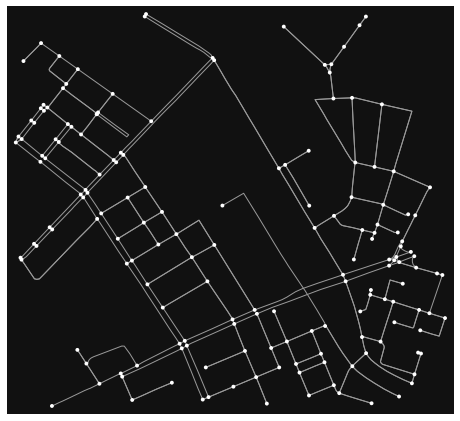

In [2]:
# Prepare POI
gasstations = gpd.read_file("data/gas-stations.geojson")
gasstations["geometry"].crs
gasstations["x"] = gasstations.centroid.x
gasstations["y"] = gasstations.centroid.y

# Prepare Network
filter_road_network_accessible_by_car = (
    '["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential"]'
)
streetmap_berlin_bbox = {
    "north": 52.539,
    "south": 52.524,
    "west": 13.437,
    "east": 13.464,
}
NETWORK = ox.graph_from_bbox(
    north=streetmap_berlin_bbox["north"],
    south=streetmap_berlin_bbox["south"],
    west=streetmap_berlin_bbox["west"],
    east=streetmap_berlin_bbox["east"],
    custom_filter=filter_road_network_accessible_by_car,
)

# The algorithms require POI to be nodes in the network
POI = ox.distance.get_nearest_nodes(
    NETWORK, gasstations.x, gasstations.y, method="balltree"
)

# Output stats and plot the network
nodes, edges = ox.graph_to_gdfs(NETWORK)
print(f"Number of nodes: {NETWORK.number_of_nodes()}")
print(f"Number of edges: {NETWORK.number_of_edges()}")
ox.plot_graph(NETWORK)
plt.show()

In [3]:
nodes.head()

,y,x,osmid,highway,geometry
12614600,52.526522,13.447766,12614600,NaN,POINT (13.44777 52.52652)
12614650,52.529562,13.444474,12614650,NaN,POINT (13.44447 52.52956)
12614681,52.534264,13.437406,12614681,NaN,POINT (13.43741 52.53426)
27195116,52.524911,13.461917,27195116,NaN,POINT (13.46192 52.52491)
27195138,52.526040,13.462484,27195138,NaN,POINT (13.46248 52.52604)


In [4]:
edges.head()

,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,ref,bridge,tunnel,access,width,service,u,v,key
0,4615465,True,2,Landsberger Allee,primary,50,24.987,"LINESTRING (13.44777 52.52652, 13.44770 52.526...",NaN,NaN,NaN,NaN,NaN,NaN,12614600,29270276,0
1,"[656241856, 823635965, 823635966]",True,"[2, 3]",Danziger Straße,primary,50,167.860,"LINESTRING (13.44777 52.52652, 13.44769 52.526...",B 96a,NaN,NaN,NaN,NaN,NaN,12614600,29784567,0
2,8084125,False,NaN,Paul-Heyse-Straße,residential,30,130.348,"LINESTRING (13.44447 52.52956, 13.44463 52.529...",NaN,NaN,NaN,NaN,NaN,NaN,12614650,27195457,0
3,69166200,False,NaN,Paul-Heyse-Straße,residential,50,25.129,"LINESTRING (13.44447 52.52956, 13.44435 52.529...",NaN,NaN,NaN,NaN,NaN,NaN,12614650,243856097,0
4,823635963,True,2,Danziger Straße,primary,50,109.626,"LINESTRING (13.44447 52.52956, 13.44436 52.529...",B 96a,NaN,NaN,NaN,NaN,NaN,12614650,29784565,0


## Implementation of Edge Network Voronoi Diagram

In [7]:
class EdgeNetworkVoronoiDiagram:
    def __init__(self, points_of_interest, network):
        self.points_of_interest = points_of_interest
        self.network = network
        self.nodes_by_poi, self.__poi_by_node = self.__map_poi_and_nodes()
        self.__cell_hex_colors = ox.plot.get_colors(
            n=len(self.points_of_interest), cmap="tab10", return_hex=True
        )
        self.__colorid_by_node = self.__map_nodes_and_colors()
        self.shortest_length_by_node = self.__map_nodes_and_shortestlength()
        self.envd = self.run()

    def __map_poi_and_nodes(self):
        # compute mapping: POI -> SET {(Node, ShortestPathLength)...}
        nodes_by_poi = voronoi_cells_lengths(
            self.network, list(self.points_of_interest), weight="length"
        )
        # delete unreachable nodes
        if "unreachable" in nodes_by_poi:
            self.network.remove_nodes_from(nodes_by_poi["unreachable"])
            del nodes_by_poi["unreachable"]
        # compute mapping: Node -> POI
        poi_by_node = {
            node: nearest_poi
            for nearest_poi, nodes in nodes_by_poi.items()
            for node, _ in nodes
        }
        return nodes_by_poi, poi_by_node

    def __map_nodes_and_colors(self):
        colorid_by_poi = {
            poi: colorid for colorid, poi in enumerate(self.points_of_interest)
        }
        colorid_by_node = {
            node: colorid_by_poi[poi]
            for poi, nodes in self.nodes_by_poi.items()
            for node, _ in nodes
        }
        #print(colorid_by_node)
        return colorid_by_node

    def __map_nodes_and_shortestlength(self):
        shortestlength_by_node = dict(chain.from_iterable(self.nodes_by_poi.values()))
        return shortestlength_by_node

    def run(self):
        delete_edges = []
        add_edges = []
        add_nodes = []
        envd = copy.deepcopy(self.network)
        nodes = envd.nodes()
        for node1, node2, edge_data in envd.edges.data():
            cell1_color = self.__colorid_by_node[node1]
            cell2_color = self.__colorid_by_node[node2]
            if cell1_color == cell2_color:
                # if both nodes of a edge have the same poi, then
                # all points on the edge have the same poi
                edge_data["color"] = cell1_color
            else:
                # else find the split point
                if "geometry" in edge_data:
                    edge_line = edge_data["geometry"]
                else:
                    edge_line = LineString(
                        [
                            Point(nodes[node1]["x"], nodes[node1]["y"]),
                            Point(nodes[node2]["x"], nodes[node2]["y"]),
                        ]
                    )
                node1_distance_to_splitpoint = (self.shortest_length_by_node[node2] - self.shortest_length_by_node[node1] + edge_data["length"])*0.5
                if node1_distance_to_splitpoint <= 0.0:
                    edge_data["color"] = cell2_color
                elif node1_distance_to_splitpoint >= edge_data["length"]:
                    edge_data["color"] = cell1_color
                else:
                    # scale the value to perform cut operation on geometrical object
                    cut_scaled_distance = edge_line.length * (node1_distance_to_splitpoint / edge_data["length"])
                    seg1, seg2 = cut(edge_line, cut_scaled_distance)
                    delete_edges.append((node1, node2))
                    splitpoint_id = -1 * node1
                    add_nodes.append(
                        (
                            splitpoint_id,
                            {
                                "x": seg1.coords[-1][0],
                                "y": seg1.coords[-1][1],
                                "osmid": -1 * nodes[node1]["osmid"],
                            },
                        )
                    )
                    add_edges.append(
                        (
                            node1,
                            splitpoint_id,
                            {
                                "geometry": seg1,
                                "length": node1_distance_to_splitpoint,
                                "color": cell1_color,
                                "osmid": edge_data["osmid"],
                            },
                        )
                    )
                    add_edges.append(
                        (
                            splitpoint_id,
                            node2,
                            {
                                "geometry": seg2,
                                "length": edge_data["length"] - node1_distance_to_splitpoint,
                                "color": cell2_color,
                                "osmid": -1 * edge_data["osmid"],
                            },
                        )
                    )

        envd.add_nodes_from(add_nodes)
        envd.remove_edges_from(delete_edges)
        envd.add_edges_from(add_edges)
        return envd

    def get_node_hex_colors(self):
        return [
            self.__cell_hex_colors[self.__colorid_by_node[node]]
            if node in self.__colorid_by_node
            else "none"
            for node in self.network.nodes()
        ]

    def plot(self, figsize=(20, 20), node_color="#FFFFFF", poi_size=100, node_size=0):
        # plot nodes above edges
        NODE_ZORDER = 2

        fig, ax = ox.plot_graph(
            self.envd,
            figsize=figsize,
            node_color=node_color,
            node_zorder=NODE_ZORDER,
            node_size=[
                poi_size if node in self.points_of_interest else node_size
                for node in self.envd.nodes()
            ],
            edge_color=[
                self.__cell_hex_colors[color]
                for _, _, color in self.envd.edges.data("color")
            ],
        )
        plt.show()

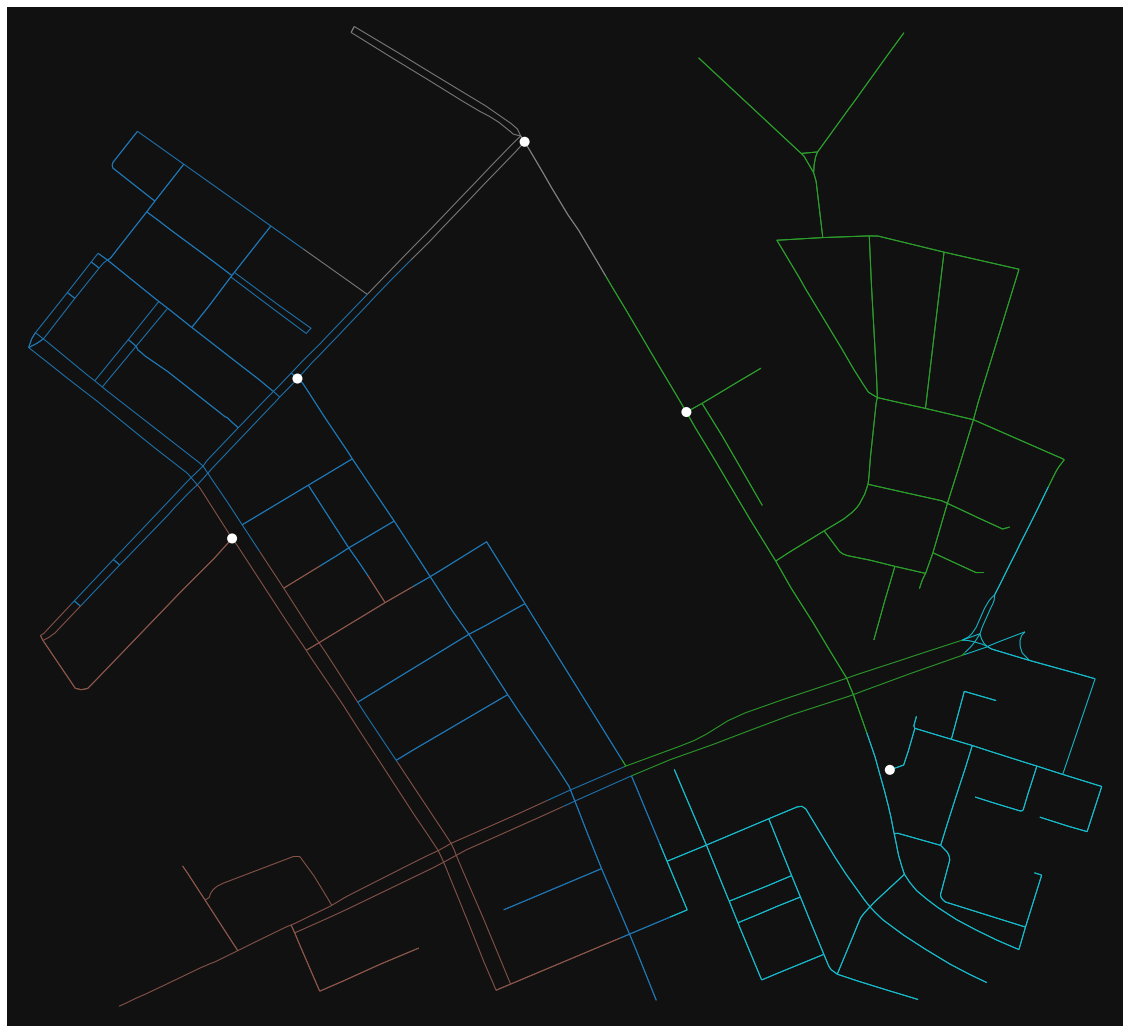

In [8]:
envd = EdgeNetworkVoronoiDiagram(POI, NETWORK)
envd.plot()
